In [1]:
#!/usr/bin/env python3
"""
Clear Cut Biomass Statistical Distribution Analysis for Jupyter Notebook
=======================================================================

This notebook script analyzes clear cut biomass data from a CSV file with columns:
[biomass, forest_type, x, y]

The analysis includes:
1. Statistical distribution fitting (normal, lognormal, gamma, Weibull)
2. Forest type stratification
3. Comprehensive descriptive statistics
4. Professional visualizations
5. Results export

Author: Forest Analysis Team
Date: 2025
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style for notebooks
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

class BiomassStatisticalAnalyzer:
    def __init__(self, csv_path):
        """Initialize the statistical analyzer"""
        self.csv_path = csv_path
        self.data = None
        self.results = {}
        self.output_dir = os.path.dirname(csv_path) if os.path.dirname(csv_path) else '.'
        
    def load_and_clean_data(self):
        """Load CSV data and perform basic cleaning"""
        try:
            print("📊 Loading CSV data...")
            self.data = pd.read_csv(self.csv_path)
            
            # Validate required columns
            required_cols = ['biomass', 'forest_type']
            missing_cols = [col for col in required_cols if col not in self.data.columns]
            
            if missing_cols:
                raise ValueError(f"Missing required columns: {missing_cols}")
            
            # Display initial data info
            print(f"✅ Initial data loaded: {len(self.data)} records")
            print(f"📋 Columns found: {list(self.data.columns)}")
            
            # Clean data
            initial_count = len(self.data)
            self.data = self.data.dropna(subset=['biomass', 'forest_type'])
            self.data = self.data[self.data['biomass'] > 0]  # Remove zero/negative biomass
            
            # Remove extreme outliers (beyond 3 standard deviations)
            biomass_mean = self.data['biomass'].mean()
            biomass_std = self.data['biomass'].std()
            outlier_threshold = 3 * biomass_std
            
            self.data = self.data[
                (self.data['biomass'] >= biomass_mean - outlier_threshold) & 
                (self.data['biomass'] <= biomass_mean + outlier_threshold)
            ]
            
            cleaned_count = len(self.data)
            removed_count = initial_count - cleaned_count
            
            print(f"🧹 Cleaned data: {cleaned_count} records")
            print(f"🗑️  Removed {removed_count} invalid/outlier records ({removed_count/initial_count*100:.1f}%)")
            print(f"🌲 Forest types found: {list(self.data['forest_type'].unique())}")
            print(f"📈 Biomass range: {self.data['biomass'].min():.1f} - {self.data['biomass'].max():.1f} t/ha")
            
            # Display basic info about forest types
            print("\n📊 Forest Type Distribution:")
            type_counts = self.data['forest_type'].value_counts()
            for forest_type, count in type_counts.items():
                percentage = (count / len(self.data)) * 100
                print(f"   • {forest_type}: {count} records ({percentage:.1f}%)")
            
            return True
            
        except Exception as e:
            print(f"❌ Error loading data: {str(e)}")
            return False
    
    def calculate_descriptive_statistics(self, data_series, stratum_name):
        """Calculate comprehensive descriptive statistics"""
        n = len(data_series)
        
        if n == 0:
            return None
            
        # Basic statistics
        mean_val = data_series.mean()
        median_val = data_series.median()
        std_val = data_series.std()
        var_val = data_series.var()
        
        # Percentiles
        percentiles = [5, 10, 25, 75, 90, 95]
        percentile_values = {f'p{p}': data_series.quantile(p/100) for p in percentiles}
        
        # Range and IQR
        min_val = data_series.min()
        max_val = data_series.max()
        range_val = max_val - min_val
        iqr = percentile_values['p75'] - percentile_values['p25']
        
        # Shape statistics
        skewness = stats.skew(data_series)
        kurtosis_val = stats.kurtosis(data_series)
        
        # Coefficient of variation
        cv = (std_val / mean_val) * 100 if mean_val != 0 else 0
        
        # Standard error of the mean
        sem = std_val / np.sqrt(n) if n > 1 else 0
        
        # 95% confidence interval for mean
        ci_95 = stats.t.interval(0.95, n-1, loc=mean_val, scale=sem) if n > 1 else (mean_val, mean_val)
        
        stats_dict = {
            'stratum': stratum_name,
            'sample_size': n,
            'mean': mean_val,
            'median': median_val,
            'std_dev': std_val,
            'variance': var_val,
            'min': min_val,
            'max': max_val,
            'range': range_val,
            'iqr': iqr,
            'cv_percent': cv,
            'skewness': skewness,
            'kurtosis': kurtosis_val,
            'std_error_mean': sem,
            'ci_95_lower': ci_95[0],
            'ci_95_upper': ci_95[1],
            **percentile_values
        }
        
        return stats_dict
    
    def fit_probability_distributions(self, data_series, stratum_name):
        """Fit multiple probability distributions and find the best fit"""
        print(f"🔍 Fitting distributions for {stratum_name}...")
        
        # Ensure we have positive data for log-based distributions
        data_positive = data_series[data_series > 0]
        
        if len(data_positive) < 10:
            print(f"⚠️  Insufficient data for distribution fitting: {len(data_positive)} samples")
            return {}
        
        # Define distributions to test
        distributions = {
            'normal': stats.norm,
            'lognormal': stats.lognorm,
            'gamma': stats.gamma,
            'weibull_min': stats.weibull_min,
            'exponential': stats.expon,
            'beta': stats.beta
        }
        
        results = {}
        fit_scores = {}
        
        for dist_name, distribution in distributions.items():
            try:
                # Fit distribution parameters
                if dist_name == 'lognormal':
                    # For lognormal, fit to log of data
                    params = distribution.fit(data_positive, floc=0)
                elif dist_name == 'beta':
                    # Beta distribution needs data scaled to [0,1]
                    data_scaled = (data_positive - data_positive.min()) / (data_positive.max() - data_positive.min())
                    params = distribution.fit(data_scaled)
                else:
                    params = distribution.fit(data_positive)
                
                # Calculate log-likelihood
                if dist_name == 'beta':
                    log_likelihood = np.sum(distribution.logpdf(data_scaled, *params))
                else:
                    log_likelihood = np.sum(distribution.logpdf(data_positive, *params))
                
                # Calculate AIC and BIC
                k = len(params)  # number of parameters
                n = len(data_positive)
                aic = 2 * k - 2 * log_likelihood
                bic = k * np.log(n) - 2 * log_likelihood
                
                # Kolmogorov-Smirnov test
                if dist_name == 'beta':
                    ks_stat, ks_p = stats.kstest(data_scaled, 
                                               lambda x: distribution.cdf(x, *params))
                else:
                    ks_stat, ks_p = stats.kstest(data_positive, 
                                               lambda x: distribution.cdf(x, *params))
                
                # Anderson-Darling test (for some distributions)
                try:
                    if dist_name == 'normal':
                        ad_stat, ad_critical, ad_significance = stats.anderson(data_positive, dist='norm')
                    elif dist_name == 'exponential':
                        ad_stat, ad_critical, ad_significance = stats.anderson(data_positive, dist='expon')
                    else:
                        ad_stat = None
                except:
                    ad_stat = None
                
                # Store results
                results[dist_name] = {
                    'distribution': distribution,
                    'params': params,
                    'param_names': self._get_param_names(distribution),
                    'log_likelihood': log_likelihood,
                    'aic': aic,
                    'bic': bic,
                    'ks_statistic': ks_stat,
                    'ks_p_value': ks_p,
                    'anderson_darling': ad_stat,
                    'n_params': k
                }
                
                # Score for ranking (lower is better)
                fit_scores[dist_name] = aic
                
                print(f"   • {dist_name}: AIC={aic:.2f}, KS p-value={ks_p:.4f}")
                
            except Exception as e:
                print(f"   ❌ Failed to fit {dist_name}: {str(e)}")
                continue
        
        # Find best fits
        if fit_scores:
            # Best by AIC
            best_aic = min(fit_scores.keys(), key=lambda k: fit_scores[k])
            results['best_fit_aic'] = best_aic
            
            # Calculate AIC weights (for model averaging)
            min_aic = min(fit_scores.values())
            aic_weights = {}
            total_weight = 0
            
            for dist_name, aic_val in fit_scores.items():
                weight = np.exp((min_aic - aic_val) / 2)
                aic_weights[dist_name] = weight
                total_weight += weight
            
            # Normalize weights
            for dist_name in aic_weights:
                aic_weights[dist_name] /= total_weight
            
            results['aic_weights'] = aic_weights
            
            print(f"   🏆 Best fit for {stratum_name}: {best_aic} (AIC: {fit_scores[best_aic]:.2f})")
        
        return results
    
    def _get_param_names(self, distribution):
        """Get parameter names for common distributions"""
        dist_name = distribution.name
        
        param_names = {
            'norm': ['loc (mean)', 'scale (std)'],
            'lognorm': ['s (shape)', 'loc', 'scale'],
            'gamma': ['a (shape)', 'loc', 'scale'],
            'weibull_min': ['c (shape)', 'loc', 'scale'],
            'expon': ['loc', 'scale'],
            'beta': ['a', 'b', 'loc', 'scale']
        }
        
        return param_names.get(dist_name, ['param_' + str(i) for i in range(4)])
    
    def display_summary_statistics(self):
        """Display summary statistics in a nice format"""
        if not self.results['descriptive_stats']:
            print("❌ No statistics available")
            return
        
        print("\n" + "="*80)
        print("📊 DESCRIPTIVE STATISTICS SUMMARY")
        print("="*80)
        
        # Create a nice summary table
        stats_df = pd.DataFrame(self.results['descriptive_stats'])
        
        # Select key columns for display
        display_cols = ['stratum', 'sample_size', 'mean', 'median', 'std_dev', 
                       'min', 'max', 'p5', 'p95', 'cv_percent', 'skewness']
        
        display_df = stats_df[display_cols].copy()
        
        # Round numerical columns
        numerical_cols = ['mean', 'median', 'std_dev', 'min', 'max', 'p5', 'p95', 'cv_percent', 'skewness']
        for col in numerical_cols:
            if col in display_df.columns:
                display_df[col] = display_df[col].round(2)
        
        # Rename columns for better display
        display_df.columns = ['Stratum', 'N', 'Mean', 'Median', 'Std Dev', 
                             'Min', 'Max', '5th %ile', '95th %ile', 'CV%', 'Skewness']
        
        print(display_df.to_string(index=False))
        
        # Distribution fitting summary
        print("\n" + "="*80)
        print("🎯 BEST-FIT DISTRIBUTIONS")
        print("="*80)
        
        for stratum, dist_data in self.results['distributions'].items():
            if 'best_fit_aic' in dist_data:
                best_dist = dist_data['best_fit_aic']
                best_info = dist_data[best_dist]
                
                print(f"\n🌲 {stratum}:")
                print(f"   Best Distribution: {best_dist}")
                print(f"   AIC: {best_info['aic']:.2f}")
                print(f"   KS Test p-value: {best_info['ks_p_value']:.4f}")
                
                # Format parameters nicely
                param_str = ', '.join([f'{name}={val:.3f}' 
                                     for name, val in zip(best_info['param_names'], 
                                                        best_info['params'])])
                print(f"   Parameters: {param_str}")
                
                # Interpretation
                if best_info['ks_p_value'] > 0.05:
                    print(f"   ✅ Fit Quality: Good (p > 0.05)")
                else:
                    print(f"   ⚠️  Fit Quality: Poor (p < 0.05)")
    
    def create_statistical_visualizations(self):
        """Create comprehensive statistical visualizations"""
        print("\n🎨 Creating statistical visualizations...")
        
        # Get forest types
        forest_types = self.data['forest_type'].unique()
        n_types = len(forest_types)
        
        # Create main figure with subplots
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Overall distribution histogram with fitted curves
        ax1 = plt.subplot(3, 4, 1)
        biomass_data = self.data['biomass']
        
        # Histogram
        counts, bins, patches = ax1.hist(biomass_data, bins=40, alpha=0.7, density=True, 
                                        color='skyblue', edgecolor='black', linewidth=0.5)
        
        # Fit and plot best distribution
        if 'Overall' in self.results['distributions']:
            best_dist_name = self.results['distributions']['Overall'].get('best_fit_aic')
            if best_dist_name:
                dist_info = self.results['distributions']['Overall'][best_dist_name]
                distribution = dist_info['distribution']
                params = dist_info['params']
                
                x = np.linspace(biomass_data.min(), biomass_data.max(), 100)
                y = distribution.pdf(x, *params)
                ax1.plot(x, y, 'r-', linewidth=2, label=f'Best fit: {best_dist_name}')
        
        ax1.axvline(biomass_data.mean(), color='red', linestyle='--', alpha=0.8,
                   label=f'Mean: {biomass_data.mean():.1f}')
        ax1.axvline(biomass_data.median(), color='orange', linestyle='--', alpha=0.8,
                   label=f'Median: {biomass_data.median():.1f}')
        ax1.set_xlabel('Biomass (t/ha)')
        ax1.set_ylabel('Density')
        ax1.set_title('Overall Biomass Distribution\nwith Best-Fit Curve')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Q-Q plot for overall data (normal)
        ax2 = plt.subplot(3, 4, 2)
        stats.probplot(biomass_data, dist="norm", plot=ax2)
        ax2.set_title('Q-Q Plot vs Normal Distribution')
        ax2.grid(True, alpha=0.3)
        
        # 3. Box plot comparison by forest type
        ax3 = plt.subplot(3, 4, 3)
        box_data = [self.data[self.data['forest_type'] == ft]['biomass'].values 
                   for ft in forest_types]
        bp = ax3.boxplot(box_data, labels=forest_types, patch_artist=True)
        
        # Color the boxes
        colors = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax3.set_xlabel('Forest Type')
        ax3.set_ylabel('Biomass (t/ha)')
        ax3.set_title('Biomass Distribution\nby Forest Type')
        ax3.grid(True, alpha=0.3)
        plt.setp(ax3.get_xticklabels(), rotation=45)
        
        # 4. Violin plot by forest type
        ax4 = plt.subplot(3, 4, 4)
        violin_data = []
        violin_labels = []
        for ft in forest_types:
            ft_data = self.data[self.data['forest_type'] == ft]['biomass']
            if len(ft_data) > 5:  # Only plot if sufficient data
                violin_data.append(ft_data.values)
                violin_labels.append(f'{ft}\n(n={len(ft_data)})')
        
        if violin_data:
            vp = ax4.violinplot(violin_data, positions=range(1, len(violin_data)+1))
            ax4.set_xticks(range(1, len(violin_labels)+1))
            ax4.set_xticklabels(violin_labels, rotation=45)
        
        ax4.set_xlabel('Forest Type')
        ax4.set_ylabel('Biomass (t/ha)')
        ax4.set_title('Biomass Density Distribution\nby Forest Type')
        ax4.grid(True, alpha=0.3)
        
        # 5-8. Individual forest type histograms with fits
        colors_cycle = plt.cm.Set3(np.linspace(0, 1, max(4, len(forest_types))))
        for i, forest_type in enumerate(forest_types[:4]):  # Show up to 4 types
            ax = plt.subplot(3, 4, 5+i)
            ft_data = self.data[self.data['forest_type'] == forest_type]['biomass']
            
            if len(ft_data) < 10:
                ax.text(0.5, 0.5, f'Insufficient data\n({len(ft_data)} samples)', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{forest_type}')
                continue
            
            # Histogram
            counts, bins, patches = ax.hist(ft_data, bins=20, alpha=0.7, density=True,
                                          color=colors_cycle[i], edgecolor='black', 
                                          linewidth=0.5)
            
            # Fit and plot best distribution
            if forest_type in self.results['distributions']:
                best_dist_name = self.results['distributions'][forest_type].get('best_fit_aic')
                if best_dist_name:
                    dist_info = self.results['distributions'][forest_type][best_dist_name]
                    distribution = dist_info['distribution']
                    params = dist_info['params']
                    
                    x = np.linspace(ft_data.min(), ft_data.max(), 100)
                    y = distribution.pdf(x, *params)
                    ax.plot(x, y, 'r-', linewidth=2, label=f'{best_dist_name}')
            
            ax.axvline(ft_data.mean(), color='red', linestyle='--', alpha=0.8)
            ax.axvline(ft_data.median(), color='orange', linestyle='--', alpha=0.8)
            ax.set_xlabel('Biomass (t/ha)')
            ax.set_ylabel('Density')
            ax.set_title(f'{forest_type}\n(n={len(ft_data)})')
            if 'best_dist_name' in locals() and best_dist_name:
                ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 9. Distribution comparison plot
        ax9 = plt.subplot(3, 4, 9)
        if 'Overall' in self.results['distributions']:
            dist_results = self.results['distributions']['Overall']
            if 'aic_weights' in dist_results:
                weights = dist_results['aic_weights']
                dist_names = list(weights.keys())
                weight_values = list(weights.values())
                
                bars = ax9.bar(dist_names, weight_values, alpha=0.7, color='lightblue')
                ax9.set_xlabel('Distribution')
                ax9.set_ylabel('AIC Weight')
                ax9.set_title('Distribution Model Weights\n(Higher = Better Fit)')
                plt.setp(ax9.get_xticklabels(), rotation=45)
                ax9.grid(True, alpha=0.3)
                
                # Highlight best fit
                best_idx = weight_values.index(max(weight_values))
                bars[best_idx].set_color('red')
                bars[best_idx].set_alpha(0.9)
        
        # 10. Cumulative distribution comparison
        ax10 = plt.subplot(3, 4, 10)
        for i, forest_type in enumerate(forest_types):
            ft_data = self.data[self.data['forest_type'] == forest_type]['biomass']
            if len(ft_data) > 10:
                sorted_data = np.sort(ft_data)
                cumulative = np.arange(1, len(sorted_data)+1) / len(sorted_data)
                ax10.plot(sorted_data, cumulative, label=f'{forest_type} (n={len(ft_data)})', 
                         linewidth=2, alpha=0.8)
        
        ax10.set_xlabel('Biomass (t/ha)')
        ax10.set_ylabel('Cumulative Probability')
        ax10.set_title('Cumulative Distribution\nComparison')
        ax10.legend()
        ax10.grid(True, alpha=0.3)
        
        # 11. Statistical summary heatmap
        ax11 = plt.subplot(3, 4, 11)
        if self.results['descriptive_stats']:
            # Create summary matrix
            stats_df = pd.DataFrame(self.results['descriptive_stats'])
            stats_subset = stats_df[['stratum', 'mean', 'median', 'std_dev', 'skewness', 'kurtosis']].set_index('stratum')
            
            # Normalize for heatmap
            stats_normalized = stats_subset.div(stats_subset.max())
            
            sns.heatmap(stats_normalized.T, annot=True, cmap='YlOrRd', ax=ax11, fmt='.2f')
            ax11.set_title('Normalized Statistical\nParameters Heatmap')
            ax11.set_xlabel('Stratum')
        
        # 12. Model fit quality comparison
        ax12 = plt.subplot(3, 4, 12)
        fit_quality = []
        strata = []
        
        for stratum, dist_data in self.results['distributions'].items():
            if 'best_fit_aic' in dist_data:
                best_dist = dist_data['best_fit_aic']
                ks_p = dist_data[best_dist]['ks_p_value']
                fit_quality.append(ks_p)
                strata.append(stratum)
        
        if fit_quality:
            bars = ax12.bar(strata, fit_quality, alpha=0.7, color='lightgreen')
            ax12.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='α = 0.05')
            ax12.set_xlabel('Stratum')
            ax12.set_ylabel('KS Test p-value')
            ax12.set_title('Distribution Fit Quality\n(Higher = Better Fit)')
            ax12.legend()
            plt.setp(ax12.get_xticklabels(), rotation=45)
            ax12.grid(True, alpha=0.3)
            
            # Color bars based on significance
            for i, (bar, p_val) in enumerate(zip(bars, fit_quality)):
                if p_val < 0.05:
                    bar.set_color('orange')  # Poor fit
                elif p_val > 0.1:
                    bar.set_color('green')   # Good fit
        
        plt.tight_layout()
        
        # Save the comprehensive plot
        plot_path = os.path.join(self.output_dir, 'biomass_statistical_analysis.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"📊 Statistical plots saved to: {plot_path}")
        
        plt.show()
    
    def export_results(self):
        """Export all statistical results to CSV files"""
        print("\n💾 Exporting results...")
        
        # 1. Export descriptive statistics
        if self.results['descriptive_stats']:
            stats_df = pd.DataFrame(self.results['descriptive_stats'])
            stats_path = os.path.join(self.output_dir, 'biomass_descriptive_statistics.csv')
            stats_df.to_csv(stats_path, index=False)
            print(f"📁 Descriptive statistics saved to: {stats_path}")
        
        # 2. Export distribution fitting results
        dist_results = []
        for stratum, dist_data in self.results['distributions'].items():
            if 'best_fit_aic' in dist_data:
                best_dist = dist_data['best_fit_aic']
                best_info = dist_data[best_dist]
                
                # Format parameters
                param_str = ', '.join([f'{name}={val:.4f}' 
                                     for name, val in zip(best_info['param_names'], 
                                                        best_info['params'])])
                
                dist_results.append({
                    'stratum': stratum,
                    'best_distribution': best_dist,
                    'parameters': param_str,
                    'aic': best_info['aic'],
                    'bic': best_info['bic'],
                    'log_likelihood': best_info['log_likelihood'],
                    'ks_statistic': best_info['ks_statistic'],
                    'ks_p_value': best_info['ks_p_value'],
                    'anderson_darling': best_info.get('anderson_darling', 'N/A')
                })
                
                # Add all distribution comparison
                for dist_name, info in dist_data.items():
                    if dist_name not in ['best_fit_aic', 'aic_weights'] and isinstance(info, dict):
                        dist_results.append({
                            'stratum': f"{stratum}_{dist_name}",
                            'best_distribution': dist_name,
                            'parameters': ', '.join([f'{name}={val:.4f}' 
                                                   for name, val in zip(info['param_names'], 
                                                                      info['params'])]),
                            'aic': info['aic'],
                            'bic': info['bic'],
                            'log_likelihood': info['log_likelihood'],
                            'ks_statistic': info['ks_statistic'],
                            'ks_p_value': info['ks_p_value'],
                            'anderson_darling': info.get('anderson_darling', 'N/A')
                        })
        
        if dist_results:
            dist_df = pd.DataFrame(dist_results)
            dist_path = os.path.join(self.output_dir, 'biomass_distribution_parameters.csv')
            dist_df.to_csv(dist_path, index=False)
            print(f"📁 Distribution parameters saved to: {dist_path}")
        
        # 3. Create detailed summary report
        self.create_summary_report()
        
        print("✅ All results exported successfully!")
    
    def create_summary_report(self):
        """Create a detailed statistical summary report"""
        report_path = os.path.join(self.output_dir, 'biomass_statistical_summary.txt')
        
        with open(report_path, 'w') as f:
            f.write("CLEAR CUT BIOMASS STATISTICAL ANALYSIS REPORT\n")
            f.write("=" * 55 + "\n\n")
            
            f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Data Source: {os.path.basename(self.csv_path)}\n")
            f.write(f"Total Records Analyzed: {len(self.data)}\n\n")
            
            # Overall summary
            f.write("OVERALL DATASET SUMMARY\n")
            f.write("-" * 30 + "\n")
            overall_stats = next((s for s in self.results['descriptive_stats'] if s['stratum'] == 'Overall'), None)
            if overall_stats:
                f.write(f"Sample Size: {overall_stats['sample_size']}\n")
                f.write(f"Mean Biomass: {overall_stats['mean']:.1f} ± {overall_stats['std_error_mean']:.1f} t/ha\n")
                f.write(f"Median Biomass: {overall_stats['median']:.1f} t/ha\n")
                f.write(f"Standard Deviation: {overall_stats['std_dev']:.1f} t/ha\n")
                f.write(f"Range: {overall_stats['min']:.1f} - {overall_stats['max']:.1f} t/ha\n")
                f.write(f"95% Confidence Interval: {overall_stats['ci_95_lower']:.1f} - {overall_stats['ci_95_upper']:.1f} t/ha\n")
                f.write(f"Coefficient of Variation: {overall_stats['cv_percent']:.1f}%\n")
                f.write(f"Skewness: {overall_stats['skewness']:.3f}\n")
                f.write(f"Kurtosis: {overall_stats['kurtosis']:.3f}\n\n")
            
            # Distribution fitting results
            f.write("BEST-FIT PROBABILITY DISTRIBUTIONS\n")
            f.write("-" * 40 + "\n")
            for stratum, dist_data in self.results['distributions'].items():
                if 'best_fit_aic' in dist_data:
                    best_dist = dist_data['best_fit_aic']
                    best_info = dist_data[best_dist]
                    
                    f.write(f"\n{stratum}:\n")
                    f.write(f"  Best Distribution: {best_dist}\n")
                    f.write(f"  Parameters: {', '.join([f'{name}={val:.4f}' for name, val in zip(best_info['param_names'], best_info['params'])])}\n")
                    f.write(f"  AIC: {best_info['aic']:.2f}\n")
                    f.write(f"  BIC: {best_info['bic']:.2f}\n")
                    f.write(f"  KS Test p-value: {best_info['ks_p_value']:.4f}\n")
                    
                    # Interpretation
                    if best_info['ks_p_value'] > 0.05:
                        f.write(f"  Fit Quality: Good (p > 0.05)\n")
                    else:
                        f.write(f"  Fit Quality: Poor (p < 0.05) - consider alternative distributions\n")
            
            # Forest type breakdown
            f.write("\nFOREST TYPE DETAILED STATISTICS\n")
            f.write("-" * 40 + "\n")
            for stats in self.results['descriptive_stats']:
                if stats['stratum'] != 'Overall':
                    f.write(f"\n{stats['stratum']}:\n")
                    f.write(f"  Sample Size: {stats['sample_size']}\n")
                    f.write(f"  Mean: {stats['mean']:.1f} ± {stats['std_error_mean']:.1f} t/ha\n")
                    f.write(f"  Median: {stats['median']:.1f} t/ha\n")
                    f.write(f"  Standard Deviation: {stats['std_dev']:.1f} t/ha\n")
                    f.write(f"  5th-95th Percentile Range: {stats['p5']:.1f} - {stats['p95']:.1f} t/ha\n")
                    f.write(f"  Coefficient of Variation: {stats['cv_percent']:.1f}%\n")
                    f.write(f"  Skewness: {stats['skewness']:.3f}\n")
                    f.write(f"  Kurtosis: {stats['kurtosis']:.3f}\n")
            
            # Practical recommendations
            f.write("\nPRACTICAL RECOMMENDATIONS FOR MODELING\n")
            f.write("-" * 45 + "\n")
            f.write("Based on the statistical analysis, consider the following for CBM/GCBM modeling:\n\n")
            
            # Overall recommendations
            overall_stats = next((s for s in self.results['descriptive_stats'] if s['stratum'] == 'Overall'), None)
            if overall_stats:
                f.write(f"1. Typical biomass range for clear cuts: {overall_stats['p5']:.0f} - {overall_stats['p95']:.0f} t/ha\n")
                f.write(f"2. Most common biomass value (median): {overall_stats['median']:.0f} t/ha\n")
                f.write(f"3. High variability (CV: {overall_stats['cv_percent']:.0f}%) suggests stratification by forest type is important\n")
                
                if overall_stats['skewness'] > 1:
                    f.write("4. Strong positive skew indicates many low-biomass cuts with fewer high-biomass cuts\n")
                elif overall_stats['skewness'] < -1:
                    f.write("4. Negative skew indicates concentration of cuts in high-biomass stands\n")
                else:
                    f.write("4. Moderate skew suggests relatively balanced distribution\n")
            
            # Distribution-specific recommendations
            if 'Overall' in self.results['distributions']:
                best_dist = self.results['distributions']['Overall'].get('best_fit_aic')
                if best_dist:
                    f.write(f"\n5. Best statistical model: {best_dist} distribution\n")
                    if best_dist == 'lognormal':
                        f.write("   - Recommended for modeling: Lognormal captures the right skew typical of forest biomass\n")
                    elif best_dist == 'gamma':
                        f.write("   - Recommended for modeling: Gamma distribution is flexible for positive continuous data\n")
                    elif best_dist == 'weibull_min':
                        f.write("   - Recommended for modeling: Weibull can model various skewness patterns\n")
                    elif best_dist == 'normal':
                        f.write("   - Recommended for modeling: Normal distribution for symmetric data\n")
            
            f.write("\nDATA QUALITY ASSESSMENT\n")
            f.write("-" * 25 + "\n")
            f.write("Statistical tests for distribution fit quality:\n")
            for stratum, dist_data in self.results['distributions'].items():
                if 'best_fit_aic' in dist_data:
                    best_dist = dist_data['best_fit_aic']
                    p_value = dist_data[best_dist]['ks_p_value']
                    if p_value > 0.1:
                        quality = "Excellent"
                    elif p_value > 0.05:
                        quality = "Good"
                    else:
                        quality = "Poor"
                    f.write(f"- {stratum}: {quality} fit (KS p-value: {p_value:.4f})\n")
            
            f.write(f"\nAnalysis completed successfully!\n")
            f.write("Files generated:\n")
            f.write("- biomass_descriptive_statistics.csv (detailed statistics)\n")
            f.write("- biomass_distribution_parameters.csv (distribution fitting results)\n")
            f.write("- biomass_statistical_analysis.png (comprehensive visualizations)\n")
            f.write("- biomass_statistical_summary.txt (this report)\n")
        
        print(f"📄 Detailed report saved to: {report_path}")
    
    def run_analysis(self):
        """Run the complete statistical analysis pipeline"""
        print("🚀 Starting biomass statistical analysis...")
        print("="*60)
        
        # Load and clean data
        if not self.load_and_clean_data():
            return False
        
        # Initialize results
        self.results = {
            'descriptive_stats': [],
            'distributions': {}
        }
        
        # Analyze overall dataset
        print("\n🔍 Analyzing overall dataset...")
        overall_stats = self.calculate_descriptive_statistics(self.data['biomass'], 'Overall')
        if overall_stats:
            self.results['descriptive_stats'].append(overall_stats)
        
        overall_dist = self.fit_probability_distributions(self.data['biomass'], 'Overall')
        self.results['distributions']['Overall'] = overall_dist
        
        # Analyze by forest type
        print("\n🌲 Analyzing by forest type...")
        forest_types = self.data['forest_type'].unique()
        
        for forest_type in forest_types:
            subset = self.data[self.data['forest_type'] == forest_type]
            
            if len(subset) < 10:
                print(f"⚠️  Skipping {forest_type}: insufficient data ({len(subset)} samples)")
                continue
            
            print(f"🔍 Processing {forest_type} ({len(subset)} samples)...")
            
            # Descriptive statistics
            type_stats = self.calculate_descriptive_statistics(subset['biomass'], forest_type)
            if type_stats:
                self.results['descriptive_stats'].append(type_stats)
            
            # Distribution fitting
            type_dist = self.fit_probability_distributions(subset['biomass'], forest_type)
            self.results['distributions'][forest_type] = type_dist
        
        # Display summary
        self.display_summary_statistics()
        
        # Create visualizations
        self.create_statistical_visualizations()
        
        # Export results
        self.export_results()
        
        print("\n" + "="*60)
        print("🎉 Statistical analysis completed successfully!")
        print("="*60)
        return True

# Convenience functions for Jupyter Notebook

def analyze_biomass_csv(csv_path):
    """
    Main function to analyze biomass data from CSV file
    
    Parameters:
    -----------
    csv_path : str
        Path to CSV file with columns [biomass, forest_type, x, y]
    
    Returns:
    --------
    BiomassStatisticalAnalyzer
        The analyzer object with results
    """
    analyzer = BiomassStatisticalAnalyzer(csv_path)
    success = analyzer.run_analysis()
    
    if success:
        return analyzer
    else:
        print("❌ Analysis failed!")
        return None

def create_sample_data(output_path='sample_biomass_data.csv', n_samples=1000):
    """
    Create sample biomass data for testing
    
    Parameters:
    -----------
    output_path : str
        Path where to save the sample CSV
    n_samples : int
        Number of samples to generate
    
    Returns:
    --------
    str
        Path to the created CSV file
    """
    print(f"🔬 Creating sample data with {n_samples} records...")
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Simulate realistic biomass data for different forest types
    conifer_biomass = np.random.lognormal(mean=4.8, sigma=0.6, size=n_samples//2)  # ~120 t/ha mean
    mixed_biomass = np.random.gamma(shape=3, scale=40, size=n_samples//3)  # ~120 t/ha mean
    deciduous_biomass = np.random.weibull(2) * 150 + 50  # Weibull distribution
    
    # Create coordinates (not used in this analysis but required for CSV format)
    x_coords = np.random.uniform(300000, 700000, n_samples)
    y_coords = np.random.uniform(6600000, 7800000, n_samples)
    
    # Combine data
    biomass_data = np.concatenate([conifer_biomass, mixed_biomass, deciduous_biomass])
    forest_types = (['Conifer'] * len(conifer_biomass) + 
                   ['Mixed'] * len(mixed_biomass) + 
                   ['Deciduous'] * len(deciduous_biomass))
    
    # Resize arrays to same length
    min_len = min(len(biomass_data), len(forest_types), len(x_coords), len(y_coords))
    biomass_data = biomass_data[:min_len]
    forest_types = forest_types[:min_len]
    x_coords = x_coords[:min_len]
    y_coords = y_coords[:min_len]
    
    # Create DataFrame
    df = pd.DataFrame({
        'biomass': biomass_data,
        'forest_type': forest_types,
        'x': x_coords,
        'y': y_coords
    })
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    
    print(f"✅ Sample data created: {output_path}")
    print(f"📊 Data summary:")
    print(f"   • Total records: {len(df)}")
    print(f"   • Forest types: {list(df['forest_type'].unique())}")
    print(f"   • Biomass range: {df['biomass'].min():.1f} - {df['biomass'].max():.1f} t/ha")
    
    return output_path

def quick_stats_summary(csv_path):
    """
    Quick statistical summary without full analysis
    
    Parameters:
    -----------
    csv_path : str
        Path to CSV file
    
    Returns:
    --------
    pandas.DataFrame
        Summary statistics
    """
    print("⚡ Quick statistical summary...")
    
    # Load data
    data = pd.read_csv(csv_path)
    
    # Basic cleaning
    data = data.dropna(subset=['biomass', 'forest_type'])
    data = data[data['biomass'] > 0]
    
    # Calculate summary statistics by forest type
    summary = data.groupby('forest_type')['biomass'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max',
        lambda x: x.quantile(0.05),
        lambda x: x.quantile(0.95)
    ]).round(2)
    
    summary.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max', '5th %ile', '95th %ile']
    
    # Add overall statistics
    overall = data['biomass'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max',
        lambda x: x.quantile(0.05),
        lambda x: x.quantile(0.95)
    ]).round(2)
    
    overall.name = 'Overall'
    summary = pd.concat([summary, overall.to_frame().T])
    
    print("📊 Statistical Summary:")
    print(summary)
    
    return summary

# Example usage for Jupyter Notebook
def example_usage():
    """
    Example of how to use the analyzer in a Jupyter notebook
    """
    print("📝 EXAMPLE USAGE:")
    print("="*50)
    print()
    print("# 1. Analyze your own CSV file:")
    print("analyzer = analyze_biomass_csv('your_data.csv')")
    print()
    print("# 2. Create and analyze sample data:")
    print("sample_path = create_sample_data('test_data.csv', n_samples=1500)")
    print("analyzer = analyze_biomass_csv(sample_path)")
    print()
    print("# 3. Quick summary only:")
    print("summary = quick_stats_summary('your_data.csv')")
    print()
    print("# 4. Access results:")
    print("stats_df = pd.DataFrame(analyzer.results['descriptive_stats'])")
    print("print(stats_df)")
    print()
    print("# 5. Get best-fit distribution for a forest type:")
    print("best_dist = analyzer.results['distributions']['Conifer']['best_fit_aic']")
    print("print(f'Best distribution: {best_dist}')")

# Display example usage when imported
if __name__ == "__main__":
    example_usage()

# Ready-to-use functions for immediate analysis:

def run_full_analysis(csv_path):
    """Complete analysis with all outputs"""
    print("🚀 Running full biomass statistical analysis...")
    return analyze_biomass_csv(csv_path)

def run_sample_analysis():
    """Create sample data and run analysis"""
    print("🧪 Running analysis with sample data...")
    sample_path = create_sample_data()
    return analyze_biomass_csv(sample_path)

📝 EXAMPLE USAGE:

# 1. Analyze your own CSV file:
analyzer = analyze_biomass_csv('your_data.csv')

# 2. Create and analyze sample data:
sample_path = create_sample_data('test_data.csv', n_samples=1500)
analyzer = analyze_biomass_csv(sample_path)

# 3. Quick summary only:
summary = quick_stats_summary('your_data.csv')

# 4. Access results:
stats_df = pd.DataFrame(analyzer.results['descriptive_stats'])
print(stats_df)

# 5. Get best-fit distribution for a forest type:
best_dist = analyzer.results['distributions']['Conifer']['best_fit_aic']
print(f'Best distribution: {best_dist}')


In [5]:
analyzer = analyze_biomass_csv('output_data_trimmed_100.csv')

🚀 Starting biomass statistical analysis...
📊 Loading CSV data...
✅ Initial data loaded: 944868 records
📋 Columns found: ['biomass', 'forest_type', 'x', 'y']
🧹 Cleaned data: 944192 records
🗑️  Removed 676 invalid/outlier records (0.1%)
🌲 Forest types found: ['conifer', 'broadleaf']
📈 Biomass range: 100.0 - 453.0 t/ha

📊 Forest Type Distribution:
   • conifer: 852860 records (90.3%)
   • broadleaf: 91332 records (9.7%)

🔍 Analyzing overall dataset...
🔍 Fitting distributions for Overall...
   • normal: AIC=10608296.32, KS p-value=0.0000
   • lognormal: AIC=10754680.59, KS p-value=0.0000


KeyboardInterrupt: 

In [15]:
#removed beta

#!/usr/bin/env python3
"""
Clear Cut Biomass Statistical Distribution Analysis for Jupyter Notebook
=======================================================================

This notebook script analyzes clear cut biomass data from a CSV file with columns:
[biomass, forest_type, x, y]

The analysis includes:
1. Statistical distribution fitting (normal, lognormal, gamma, Weibull)
2. Forest type stratification
3. Comprehensive descriptive statistics
4. Professional visualizations
5. Results export

Author: Forest Analysis Team
Date: 2025
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style for notebooks
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

class BiomassStatisticalAnalyzer:
    def __init__(self, csv_path):
        """Initialize the statistical analyzer"""
        self.csv_path = csv_path
        self.data = None
        self.results = {}
        self.output_dir = os.path.dirname(csv_path) if os.path.dirname(csv_path) else '.'
        
    def load_and_clean_data(self):
        """Load CSV data and perform basic cleaning"""
        try:
            print("📊 Loading CSV data...")
            self.data = pd.read_csv(self.csv_path)
            
            # Validate required columns
            required_cols = ['biomass', 'forest_type']
            missing_cols = [col for col in required_cols if col not in self.data.columns]
            
            if missing_cols:
                raise ValueError(f"Missing required columns: {missing_cols}")
            
            # Display initial data info
            print(f"✅ Initial data loaded: {len(self.data)} records")
            print(f"📋 Columns found: {list(self.data.columns)}")
            
            # Clean data
            initial_count = len(self.data)
            self.data = self.data.dropna(subset=['biomass', 'forest_type'])
            self.data = self.data[self.data['biomass'] > 0]  # Remove zero/negative biomass
            
            # Remove extreme outliers (beyond 3 standard deviations)
            biomass_mean = self.data['biomass'].mean()
            biomass_std = self.data['biomass'].std()
            outlier_threshold = 2 * biomass_std
            
            self.data = self.data[
                (self.data['biomass'] >= biomass_mean - outlier_threshold) & 
                (self.data['biomass'] <= biomass_mean + outlier_threshold)
            ]
            
            cleaned_count = len(self.data)
            removed_count = initial_count - cleaned_count
            
            print(f"🧹 Cleaned data: {cleaned_count} records")
            print(f"🗑️  Removed {removed_count} invalid/outlier records ({removed_count/initial_count*100:.1f}%)")
            print(f"🌲 Forest types found: {list(self.data['forest_type'].unique())}")
            print(f"📈 Biomass range: {self.data['biomass'].min():.1f} - {self.data['biomass'].max():.1f} t/ha")
            
            # Display basic info about forest types
            print("\n📊 Forest Type Distribution:")
            type_counts = self.data['forest_type'].value_counts()
            for forest_type, count in type_counts.items():
                percentage = (count / len(self.data)) * 100
                print(f"   • {forest_type}: {count} records ({percentage:.1f}%)")
            
            return True
            
        except Exception as e:
            print(f"❌ Error loading data: {str(e)}")
            return False
    
    def calculate_descriptive_statistics(self, data_series, stratum_name):
        """Calculate comprehensive descriptive statistics"""
        n = len(data_series)
        
        if n == 0:
            return None
            
        # Basic statistics
        mean_val = data_series.mean()
        median_val = data_series.median()
        std_val = data_series.std()
        var_val = data_series.var()
        
        # Percentiles
        percentiles = [5, 10, 25, 75, 90, 95]
        percentile_values = {f'p{p}': data_series.quantile(p/100) for p in percentiles}
        
        # Range and IQR
        min_val = data_series.min()
        max_val = data_series.max()
        range_val = max_val - min_val
        iqr = percentile_values['p75'] - percentile_values['p25']
        
        # Shape statistics
        skewness = stats.skew(data_series)
        kurtosis_val = stats.kurtosis(data_series)
        
        # Coefficient of variation
        cv = (std_val / mean_val) * 100 if mean_val != 0 else 0
        
        # Standard error of the mean
        sem = std_val / np.sqrt(n) if n > 1 else 0
        
        # 95% confidence interval for mean
        ci_95 = stats.t.interval(0.95, n-1, loc=mean_val, scale=sem) if n > 1 else (mean_val, mean_val)
        
        stats_dict = {
            'stratum': stratum_name,
            'sample_size': n,
            'mean': mean_val,
            'median': median_val,
            'std_dev': std_val,
            'variance': var_val,
            'min': min_val,
            'max': max_val,
            'range': range_val,
            'iqr': iqr,
            'cv_percent': cv,
            'skewness': skewness,
            'kurtosis': kurtosis_val,
            'std_error_mean': sem,
            'ci_95_lower': ci_95[0],
            'ci_95_upper': ci_95[1],
            **percentile_values
        }
        
        return stats_dict
    
    def fit_probability_distributions(self, data_series, stratum_name):
        """Fit multiple probability distributions and find the best fit"""
        print(f"🔍 Fitting distributions for {stratum_name}...")
        
        # Ensure we have positive data for log-based distributions
        data_positive = data_series[data_series > 0]
        
        if len(data_positive) < 10:
            print(f"⚠️  Insufficient data for distribution fitting: {len(data_positive)} samples")
            return {}
        
        # Define distributions to test (beta distribution removed)
        distributions = {
            'normal': stats.norm,
            'lognormal': stats.lognorm,
            'gamma': stats.gamma,
            'weibull_min': stats.weibull_min,
            'exponential': stats.expon
        }
        
        results = {}
        fit_scores = {}
        
        for dist_name, distribution in distributions.items():
            try:
                # Fit distribution parameters
                if dist_name == 'lognormal':
                    # For lognormal, fit to log of data
                    params = distribution.fit(data_positive, floc=0)
                else:
                    params = distribution.fit(data_positive)
                
                # Calculate log-likelihood
                log_likelihood = np.sum(distribution.logpdf(data_positive, *params))
                
                # Calculate AIC and BIC
                k = len(params)  # number of parameters
                n = len(data_positive)
                aic = 2 * k - 2 * log_likelihood
                bic = k * np.log(n) - 2 * log_likelihood
                
                # Kolmogorov-Smirnov test
                ks_stat, ks_p = stats.kstest(data_positive, 
                                           lambda x: distribution.cdf(x, *params))
                
                # Anderson-Darling test (for some distributions)
                try:
                    if dist_name == 'normal':
                        ad_stat, ad_critical, ad_significance = stats.anderson(data_positive, dist='norm')
                    elif dist_name == 'exponential':
                        ad_stat, ad_critical, ad_significance = stats.anderson(data_positive, dist='expon')
                    else:
                        ad_stat = None
                except:
                    ad_stat = None
                
                # Store results
                results[dist_name] = {
                    'distribution': distribution,
                    'params': params,
                    'param_names': self._get_param_names(distribution),
                    'log_likelihood': log_likelihood,
                    'aic': aic,
                    'bic': bic,
                    'ks_statistic': ks_stat,
                    'ks_p_value': ks_p,
                    'anderson_darling': ad_stat,
                    'n_params': k
                }
                
                # Score for ranking (lower is better)
                fit_scores[dist_name] = aic
                
                print(f"   • {dist_name}: AIC={aic:.2f}, KS p-value={ks_p:.4f}")
                
            except Exception as e:
                print(f"   ❌ Failed to fit {dist_name}: {str(e)}")
                continue
        
        # Find best fits
        if fit_scores:
            # Best by AIC
            best_aic = min(fit_scores.keys(), key=lambda k: fit_scores[k])
            results['best_fit_aic'] = best_aic
            
            # Calculate AIC weights (for model averaging)
            min_aic = min(fit_scores.values())
            aic_weights = {}
            total_weight = 0
            
            for dist_name, aic_val in fit_scores.items():
                weight = np.exp((min_aic - aic_val) / 2)
                aic_weights[dist_name] = weight
                total_weight += weight
            
            # Normalize weights
            for dist_name in aic_weights:
                aic_weights[dist_name] /= total_weight
            
            results['aic_weights'] = aic_weights
            
            print(f"   🏆 Best fit for {stratum_name}: {best_aic} (AIC: {fit_scores[best_aic]:.2f})")
        
        return results
    
    def _get_param_names(self, distribution):
        """Get parameter names for common distributions"""
        dist_name = distribution.name
        
        param_names = {
            'norm': ['loc (mean)', 'scale (std)'],
            'lognorm': ['s (shape)', 'loc', 'scale'],
            'gamma': ['a (shape)', 'loc', 'scale'],
            'weibull_min': ['c (shape)', 'loc', 'scale'],
            'expon': ['loc', 'scale']
        }
        
        return param_names.get(dist_name, ['param_' + str(i) for i in range(4)])
    
    def display_summary_statistics(self):
        """Display summary statistics in a nice format"""
        if not self.results['descriptive_stats']:
            print("❌ No statistics available")
            return
        
        print("\n" + "="*80)
        print("📊 DESCRIPTIVE STATISTICS SUMMARY")
        print("="*80)
        
        # Create a nice summary table
        stats_df = pd.DataFrame(self.results['descriptive_stats'])
        
        # Select key columns for display
        display_cols = ['stratum', 'sample_size', 'mean', 'median', 'std_dev', 
                       'min', 'max', 'p5', 'p95', 'cv_percent', 'skewness']
        
        display_df = stats_df[display_cols].copy()
        
        # Round numerical columns
        numerical_cols = ['mean', 'median', 'std_dev', 'min', 'max', 'p5', 'p95', 'cv_percent', 'skewness']
        for col in numerical_cols:
            if col in display_df.columns:
                display_df[col] = display_df[col].round(2)
        
        # Rename columns for better display
        display_df.columns = ['Stratum', 'N', 'Mean', 'Median', 'Std Dev', 
                             'Min', 'Max', '5th %ile', '95th %ile', 'CV%', 'Skewness']
        
        print(display_df.to_string(index=False))
        
        # Distribution fitting summary
        print("\n" + "="*80)
        print("🎯 BEST-FIT DISTRIBUTIONS")
        print("="*80)
        
        for stratum, dist_data in self.results['distributions'].items():
            if 'best_fit_aic' in dist_data:
                best_dist = dist_data['best_fit_aic']
                best_info = dist_data[best_dist]
                
                print(f"\n🌲 {stratum}:")
                print(f"   Best Distribution: {best_dist}")
                print(f"   AIC: {best_info['aic']:.2f}")
                print(f"   KS Test p-value: {best_info['ks_p_value']:.4f}")
                
                # Format parameters nicely
                param_str = ', '.join([f'{name}={val:.3f}' 
                                     for name, val in zip(best_info['param_names'], 
                                                        best_info['params'])])
                print(f"   Parameters: {param_str}")
                
                # Interpretation
                if best_info['ks_p_value'] > 0.05:
                    print(f"   ✅ Fit Quality: Good (p > 0.05)")
                else:
                    print(f"   ⚠️  Fit Quality: Poor (p < 0.05)")
    
    def create_statistical_visualizations(self):
        """Create comprehensive statistical visualizations"""
        print("\n🎨 Creating statistical visualizations...")
        
        # Get forest types
        forest_types = self.data['forest_type'].unique()
        n_types = len(forest_types)
        
        # Create main figure with subplots
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Overall distribution histogram with fitted curves
        ax1 = plt.subplot(3, 4, 1)
        biomass_data = self.data['biomass']
        
        # Histogram
        counts, bins, patches = ax1.hist(biomass_data, bins=40, alpha=0.7, density=True, 
                                        color='skyblue', edgecolor='black', linewidth=0.5)
        
        # Fit and plot best distribution
        if 'Overall' in self.results['distributions']:
            best_dist_name = self.results['distributions']['Overall'].get('best_fit_aic')
            if best_dist_name:
                dist_info = self.results['distributions']['Overall'][best_dist_name]
                distribution = dist_info['distribution']
                params = dist_info['params']
                
                x = np.linspace(biomass_data.min(), biomass_data.max(), 100)
                y = distribution.pdf(x, *params)
                ax1.plot(x, y, 'r-', linewidth=2, label=f'Best fit: {best_dist_name}')
        
        ax1.axvline(biomass_data.mean(), color='red', linestyle='--', alpha=0.8,
                   label=f'Mean: {biomass_data.mean():.1f}')
        ax1.axvline(biomass_data.median(), color='orange', linestyle='--', alpha=0.8,
                   label=f'Median: {biomass_data.median():.1f}')
        ax1.set_xlabel('Biomass (t/ha)')
        ax1.set_ylabel('Density')
        ax1.set_title('Overall Biomass Distribution\nwith Best-Fit Curve')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Q-Q plot for overall data (normal)
        ax2 = plt.subplot(3, 4, 2)
        stats.probplot(biomass_data, dist="norm", plot=ax2)
        ax2.set_title('Q-Q Plot vs Normal Distribution')
        ax2.grid(True, alpha=0.3)
        
        # 3. Box plot comparison by forest type
        ax3 = plt.subplot(3, 4, 3)
        box_data = [self.data[self.data['forest_type'] == ft]['biomass'].values 
                   for ft in forest_types]
        bp = ax3.boxplot(box_data, labels=forest_types, patch_artist=True)
        
        # Color the boxes
        colors = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax3.set_xlabel('Forest Type')
        ax3.set_ylabel('Biomass (t/ha)')
        ax3.set_title('Biomass Distribution\nby Forest Type')
        ax3.grid(True, alpha=0.3)
        plt.setp(ax3.get_xticklabels(), rotation=45)
        
        # 4. Violin plot by forest type
        ax4 = plt.subplot(3, 4, 4)
        violin_data = []
        violin_labels = []
        for ft in forest_types:
            ft_data = self.data[self.data['forest_type'] == ft]['biomass']
            if len(ft_data) > 5:  # Only plot if sufficient data
                violin_data.append(ft_data.values)
                violin_labels.append(f'{ft}\n(n={len(ft_data)})')
        
        if violin_data:
            vp = ax4.violinplot(violin_data, positions=range(1, len(violin_data)+1))
            ax4.set_xticks(range(1, len(violin_labels)+1))
            ax4.set_xticklabels(violin_labels, rotation=45)
        
        ax4.set_xlabel('Forest Type')
        ax4.set_ylabel('Biomass (t/ha)')
        ax4.set_title('Biomass Density Distribution\nby Forest Type')
        ax4.grid(True, alpha=0.3)
        
        # 5-8. Individual forest type histograms with fits
        colors_cycle = plt.cm.Set3(np.linspace(0, 1, max(4, len(forest_types))))
        for i, forest_type in enumerate(forest_types[:4]):  # Show up to 4 types
            ax = plt.subplot(3, 4, 5+i)
            ft_data = self.data[self.data['forest_type'] == forest_type]['biomass']
            
            if len(ft_data) < 10:
                ax.text(0.5, 0.5, f'Insufficient data\n({len(ft_data)} samples)', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{forest_type}')
                continue
            
            # Histogram
            counts, bins, patches = ax.hist(ft_data, bins=20, alpha=0.7, density=True,
                                          color=colors_cycle[i], edgecolor='black', 
                                          linewidth=0.5)
            
            # Fit and plot best distribution
            if forest_type in self.results['distributions']:
                best_dist_name = self.results['distributions'][forest_type].get('best_fit_aic')
                if best_dist_name:
                    dist_info = self.results['distributions'][forest_type][best_dist_name]
                    distribution = dist_info['distribution']
                    params = dist_info['params']
                    
                    x = np.linspace(ft_data.min(), ft_data.max(), 100)
                    y = distribution.pdf(x, *params)
                    ax.plot(x, y, 'r-', linewidth=2, label=f'{best_dist_name}')
            
            ax.axvline(ft_data.mean(), color='red', linestyle='--', alpha=0.8)
            ax.axvline(ft_data.median(), color='orange', linestyle='--', alpha=0.8)
            ax.set_xlabel('Biomass (t/ha)')
            ax.set_ylabel('Density')
            ax.set_title(f'{forest_type}\n(n={len(ft_data)})')
            if 'best_dist_name' in locals() and best_dist_name:
                ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 9. Distribution comparison plot
        ax9 = plt.subplot(3, 4, 9)
        if 'Overall' in self.results['distributions']:
            dist_results = self.results['distributions']['Overall']
            if 'aic_weights' in dist_results:
                weights = dist_results['aic_weights']
                dist_names = list(weights.keys())
                weight_values = list(weights.values())
                
                bars = ax9.bar(dist_names, weight_values, alpha=0.7, color='lightblue')
                ax9.set_xlabel('Distribution')
                ax9.set_ylabel('AIC Weight')
                ax9.set_title('Distribution Model Weights\n(Higher = Better Fit)')
                plt.setp(ax9.get_xticklabels(), rotation=45)
                ax9.grid(True, alpha=0.3)
                
                # Highlight best fit
                best_idx = weight_values.index(max(weight_values))
                bars[best_idx].set_color('red')
                bars[best_idx].set_alpha(0.9)
        
        # 10. Cumulative distribution comparison
        ax10 = plt.subplot(3, 4, 10)
        for i, forest_type in enumerate(forest_types):
            ft_data = self.data[self.data['forest_type'] == forest_type]['biomass']
            if len(ft_data) > 10:
                sorted_data = np.sort(ft_data)
                cumulative = np.arange(1, len(sorted_data)+1) / len(sorted_data)
                ax10.plot(sorted_data, cumulative, label=f'{forest_type} (n={len(ft_data)})', 
                         linewidth=2, alpha=0.8)
        
        ax10.set_xlabel('Biomass (t/ha)')
        ax10.set_ylabel('Cumulative Probability')
        ax10.set_title('Cumulative Distribution\nComparison')
        ax10.legend()
        ax10.grid(True, alpha=0.3)
        
        # 11. Statistical summary heatmap
        ax11 = plt.subplot(3, 4, 11)
        if self.results['descriptive_stats']:
            # Create summary matrix
            stats_df = pd.DataFrame(self.results['descriptive_stats'])
            stats_subset = stats_df[['stratum', 'mean', 'median', 'std_dev', 'skewness', 'kurtosis']].set_index('stratum')
            
            # Normalize for heatmap
            stats_normalized = stats_subset.div(stats_subset.max())
            
            sns.heatmap(stats_normalized.T, annot=True, cmap='YlOrRd', ax=ax11, fmt='.2f')
            ax11.set_title('Normalized Statistical\nParameters Heatmap')
            ax11.set_xlabel('Stratum')
        
        # 12. Model fit quality comparison
        ax12 = plt.subplot(3, 4, 12)
        fit_quality = []
        strata = []
        
        for stratum, dist_data in self.results['distributions'].items():
            if 'best_fit_aic' in dist_data:
                best_dist = dist_data['best_fit_aic']
                ks_p = dist_data[best_dist]['ks_p_value']
                fit_quality.append(ks_p)
                strata.append(stratum)
        
        if fit_quality:
            bars = ax12.bar(strata, fit_quality, alpha=0.7, color='lightgreen')
            ax12.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='α = 0.05')
            ax12.set_xlabel('Stratum')
            ax12.set_ylabel('KS Test p-value')
            ax12.set_title('Distribution Fit Quality\n(Higher = Better Fit)')
            ax12.legend()
            plt.setp(ax12.get_xticklabels(), rotation=45)
            ax12.grid(True, alpha=0.3)
            
            # Color bars based on significance
            for i, (bar, p_val) in enumerate(zip(bars, fit_quality)):
                if p_val < 0.05:
                    bar.set_color('orange')  # Poor fit
                elif p_val > 0.1:
                    bar.set_color('green')   # Good fit
        
        plt.tight_layout()
        
        # Save the comprehensive plot
        plot_path = os.path.join(self.output_dir, 'biomass_statistical_analysis.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"📊 Statistical plots saved to: {plot_path}")
        
        plt.show()
    
    def export_results(self):
        """Export all statistical results to CSV files"""
        print("\n💾 Exporting results...")
        
        # 1. Export descriptive statistics
        if self.results['descriptive_stats']:
            stats_df = pd.DataFrame(self.results['descriptive_stats'])
            stats_path = os.path.join(self.output_dir, 'biomass_descriptive_statistics.csv')
            stats_df.to_csv(stats_path, index=False)
            print(f"📁 Descriptive statistics saved to: {stats_path}")
        
        # 2. Export distribution fitting results
        dist_results = []
        for stratum, dist_data in self.results['distributions'].items():
            if 'best_fit_aic' in dist_data:
                best_dist = dist_data['best_fit_aic']
                best_info = dist_data[best_dist]
                
                # Format parameters
                param_str = ', '.join([f'{name}={val:.4f}' 
                                     for name, val in zip(best_info['param_names'], 
                                                        best_info['params'])])
                
                dist_results.append({
                    'stratum': stratum,
                    'best_distribution': best_dist,
                    'parameters': param_str,
                    'aic': best_info['aic'],
                    'bic': best_info['bic'],
                    'log_likelihood': best_info['log_likelihood'],
                    'ks_statistic': best_info['ks_statistic'],
                    'ks_p_value': best_info['ks_p_value'],
                    'anderson_darling': best_info.get('anderson_darling', 'N/A')
                })
                
                # Add all distribution comparison
                for dist_name, info in dist_data.items():
                    if dist_name not in ['best_fit_aic', 'aic_weights'] and isinstance(info, dict):
                        dist_results.append({
                            'stratum': f"{stratum}_{dist_name}",
                            'best_distribution': dist_name,
                            'parameters': ', '.join([f'{name}={val:.4f}' 
                                                   for name, val in zip(info['param_names'], 
                                                                      info['params'])]),
                            'aic': info['aic'],
                            'bic': info['bic'],
                            'log_likelihood': info['log_likelihood'],
                            'ks_statistic': info['ks_statistic'],
                            'ks_p_value': info['ks_p_value'],
                            'anderson_darling': info.get('anderson_darling', 'N/A')
                        })
        
        if dist_results:
            dist_df = pd.DataFrame(dist_results)
            dist_path = os.path.join(self.output_dir, 'biomass_distribution_parameters.csv')
            dist_df.to_csv(dist_path, index=False)
            print(f"📁 Distribution parameters saved to: {dist_path}")
        
        # 3. Create detailed summary report
        self.create_summary_report()
        
        print("✅ All results exported successfully!")
    
    def create_summary_report(self):
        """Create a detailed statistical summary report"""
        report_path = os.path.join(self.output_dir, 'biomass_statistical_summary.txt')
        
        with open(report_path, 'w') as f:
            f.write("CLEAR CUT BIOMASS STATISTICAL ANALYSIS REPORT\n")
            f.write("=" * 55 + "\n\n")
            
            f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Data Source: {os.path.basename(self.csv_path)}\n")
            f.write(f"Total Records Analyzed: {len(self.data)}\n\n")
            
            # Overall summary
            f.write("OVERALL DATASET SUMMARY\n")
            f.write("-" * 30 + "\n")
            overall_stats = next((s for s in self.results['descriptive_stats'] if s['stratum'] == 'Overall'), None)
            if overall_stats:
                f.write(f"Sample Size: {overall_stats['sample_size']}\n")
                f.write(f"Mean Biomass: {overall_stats['mean']:.1f} ± {overall_stats['std_error_mean']:.1f} t/ha\n")
                f.write(f"Median Biomass: {overall_stats['median']:.1f} t/ha\n")
                f.write(f"Standard Deviation: {overall_stats['std_dev']:.1f} t/ha\n")
                f.write(f"Range: {overall_stats['min']:.1f} - {overall_stats['max']:.1f} t/ha\n")
                f.write(f"95% Confidence Interval: {overall_stats['ci_95_lower']:.1f} - {overall_stats['ci_95_upper']:.1f} t/ha\n")
                f.write(f"Coefficient of Variation: {overall_stats['cv_percent']:.1f}%\n")
                f.write(f"Skewness: {overall_stats['skewness']:.3f}\n")
                f.write(f"Kurtosis: {overall_stats['kurtosis']:.3f}\n\n")
            
            # Distribution fitting results
            f.write("BEST-FIT PROBABILITY DISTRIBUTIONS\n")
            f.write("-" * 40 + "\n")
            for stratum, dist_data in self.results['distributions'].items():
                if 'best_fit_aic' in dist_data:
                    best_dist = dist_data['best_fit_aic']
                    best_info = dist_data[best_dist]
                    
                    f.write(f"\n{stratum}:\n")
                    f.write(f"  Best Distribution: {best_dist}\n")
                    f.write(f"  Parameters: {', '.join([f'{name}={val:.4f}' for name, val in zip(best_info['param_names'], best_info['params'])])}\n")
                    f.write(f"  AIC: {best_info['aic']:.2f}\n")
                    f.write(f"  BIC: {best_info['bic']:.2f}\n")
                    f.write(f"  KS Test p-value: {best_info['ks_p_value']:.4f}\n")
                    
                    # Interpretation
                    if best_info['ks_p_value'] > 0.05:
                        f.write(f"  Fit Quality: Good (p > 0.05)\n")
                    else:
                        f.write(f"  Fit Quality: Poor (p < 0.05) - consider alternative distributions\n")
            
            # Forest type breakdown
            f.write("\nFOREST TYPE DETAILED STATISTICS\n")
            f.write("-" * 40 + "\n")
            for stats in self.results['descriptive_stats']:
                if stats['stratum'] != 'Overall':
                    f.write(f"\n{stats['stratum']}:\n")
                    f.write(f"  Sample Size: {stats['sample_size']}\n")
                    f.write(f"  Mean: {stats['mean']:.1f} ± {stats['std_error_mean']:.1f} t/ha\n")
                    f.write(f"  Median: {stats['median']:.1f} t/ha\n")
                    f.write(f"  Standard Deviation: {stats['std_dev']:.1f} t/ha\n")
                    f.write(f"  5th-95th Percentile Range: {stats['p5']:.1f} - {stats['p95']:.1f} t/ha\n")
                    f.write(f"  Coefficient of Variation: {stats['cv_percent']:.1f}%\n")
                    f.write(f"  Skewness: {stats['skewness']:.3f}\n")
                    f.write(f"  Kurtosis: {stats['kurtosis']:.3f}\n")
            
            # Practical recommendations
            f.write("\nPRACTICAL RECOMMENDATIONS FOR MODELING\n")
            f.write("-" * 45 + "\n")
            f.write("Based on the statistical analysis, consider the following for CBM/GCBM modeling:\n\n")
            
            # Overall recommendations
            overall_stats = next((s for s in self.results['descriptive_stats'] if s['stratum'] == 'Overall'), None)
            if overall_stats:
                f.write(f"1. Typical biomass range for clear cuts: {overall_stats['p5']:.0f} - {overall_stats['p95']:.0f} t/ha\n")
                f.write(f"2. Most common biomass value (median): {overall_stats['median']:.0f} t/ha\n")
                f.write(f"3. High variability (CV: {overall_stats['cv_percent']:.0f}%) suggests stratification by forest type is important\n")
                
                if overall_stats['skewness'] > 1:
                    f.write("4. Strong positive skew indicates many low-biomass cuts with fewer high-biomass cuts\n")
                elif overall_stats['skewness'] < -1:
                    f.write("4. Negative skew indicates concentration of cuts in high-biomass stands\n")
                else:
                    f.write("4. Moderate skew suggests relatively balanced distribution\n")
            
            # Distribution-specific recommendations
            if 'Overall' in self.results['distributions']:
                best_dist = self.results['distributions']['Overall'].get('best_fit_aic')
                if best_dist:
                    f.write(f"\n5. Best statistical model: {best_dist} distribution\n")
                    if best_dist == 'lognormal':
                        f.write("   - Recommended for modeling: Lognormal captures the right skew typical of forest biomass\n")
                    elif best_dist == 'gamma':
                        f.write("   - Recommended for modeling: Gamma distribution is flexible for positive continuous data\n")
                    elif best_dist == 'weibull_min':
                        f.write("   - Recommended for modeling: Weibull can model various skewness patterns\n")
                    elif best_dist == 'normal':
                        f.write("   - Recommended for modeling: Normal distribution for symmetric data\n")
            
            f.write("\nDATA QUALITY ASSESSMENT\n")
            f.write("-" * 25 + "\n")
            f.write("Statistical tests for distribution fit quality:\n")
            for stratum, dist_data in self.results['distributions'].items():
                if 'best_fit_aic' in dist_data:
                    best_dist = dist_data['best_fit_aic']
                    p_value = dist_data[best_dist]['ks_p_value']
                    if p_value > 0.1:
                        quality = "Excellent"
                    elif p_value > 0.05:
                        quality = "Good"
                    else:
                        quality = "Poor"
                    f.write(f"- {stratum}: {quality} fit (KS p-value: {p_value:.4f})\n")
            
            f.write(f"\nAnalysis completed successfully!\n")
            f.write("Files generated:\n")
            f.write("- biomass_descriptive_statistics.csv (detailed statistics)\n")
            f.write("- biomass_distribution_parameters.csv (distribution fitting results)\n")
            f.write("- biomass_statistical_analysis.png (comprehensive visualizations)\n")
            f.write("- biomass_statistical_summary.txt (this report)\n")
        
        print(f"📄 Detailed report saved to: {report_path}")
    
    def run_analysis(self):
        """Run the complete statistical analysis pipeline"""
        print("🚀 Starting biomass statistical analysis...")
        print("="*60)
        
        # Load and clean data
        if not self.load_and_clean_data():
            return False
        
        # Initialize results
        self.results = {
            'descriptive_stats': [],
            'distributions': {}
        }
        
        # Analyze overall dataset
        print("\n🔍 Analyzing overall dataset...")
        overall_stats = self.calculate_descriptive_statistics(self.data['biomass'], 'Overall')
        if overall_stats:
            self.results['descriptive_stats'].append(overall_stats)
        
        overall_dist = self.fit_probability_distributions(self.data['biomass'], 'Overall')
        self.results['distributions']['Overall'] = overall_dist
        
        # Analyze by forest type
        print("\n🌲 Analyzing by forest type...")
        forest_types = self.data['forest_type'].unique()
        
        for forest_type in forest_types:
            subset = self.data[self.data['forest_type'] == forest_type]
            
            if len(subset) < 10:
                print(f"⚠️  Skipping {forest_type}: insufficient data ({len(subset)} samples)")
                continue
            
            print(f"🔍 Processing {forest_type} ({len(subset)} samples)...")
            
            # Descriptive statistics
            type_stats = self.calculate_descriptive_statistics(subset['biomass'], forest_type)
            if type_stats:
                self.results['descriptive_stats'].append(type_stats)
            
            # Distribution fitting
            type_dist = self.fit_probability_distributions(subset['biomass'], forest_type)
            self.results['distributions'][forest_type] = type_dist
        
        # Display summary
        self.display_summary_statistics()
        
        # Create visualizations
        self.create_statistical_visualizations()
        
        # Export results
        self.export_results()
        
        print("\n" + "="*60)
        print("🎉 Statistical analysis completed successfully!")
        print("="*60)
        return True

# Convenience functions for Jupyter Notebook

def analyze_biomass_csv(csv_path):
    """
    Main function to analyze biomass data from CSV file
    
    Parameters:
    -----------
    csv_path : str
        Path to CSV file with columns [biomass, forest_type, x, y]
    
    Returns:
    --------
    BiomassStatisticalAnalyzer
        The analyzer object with results
    """
    analyzer = BiomassStatisticalAnalyzer(csv_path)
    success = analyzer.run_analysis()
    
    if success:
        return analyzer
    else:
        print("❌ Analysis failed!")
        return None

def create_sample_data(output_path='sample_biomass_data.csv', n_samples=1000):
    """
    Create sample biomass data for testing
    
    Parameters:
    -----------
    output_path : str
        Path where to save the sample CSV
    n_samples : int
        Number of samples to generate
    
    Returns:
    --------
    str
        Path to the created CSV file
    """
    print(f"🔬 Creating sample data with {n_samples} records...")
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Simulate realistic biomass data for different forest types
    conifer_biomass = np.random.lognormal(mean=4.8, sigma=0.6, size=n_samples//2)  # ~120 t/ha mean
    mixed_biomass = np.random.gamma(shape=3, scale=40, size=n_samples//3)  # ~120 t/ha mean
    deciduous_biomass = np.random.weibull(2) * 150 + 50  # Weibull distribution
    
    # Create coordinates (not used in this analysis but required for CSV format)
    x_coords = np.random.uniform(300000, 700000, n_samples)
    y_coords = np.random.uniform(6600000, 7800000, n_samples)
    
    # Combine data
    biomass_data = np.concatenate([conifer_biomass, mixed_biomass, deciduous_biomass])
    forest_types = (['Conifer'] * len(conifer_biomass) + 
                   ['Mixed'] * len(mixed_biomass) + 
                   ['Deciduous'] * len(deciduous_biomass))
    
    # Resize arrays to same length
    min_len = min(len(biomass_data), len(forest_types), len(x_coords), len(y_coords))
    biomass_data = biomass_data[:min_len]
    forest_types = forest_types[:min_len]
    x_coords = x_coords[:min_len]
    y_coords = y_coords[:min_len]
    
    # Create DataFrame
    df = pd.DataFrame({
        'biomass': biomass_data,
        'forest_type': forest_types,
        'x': x_coords,
        'y': y_coords
    })
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    
    print(f"✅ Sample data created: {output_path}")
    print(f"📊 Data summary:")
    print(f"   • Total records: {len(df)}")
    print(f"   • Forest types: {list(df['forest_type'].unique())}")
    print(f"   • Biomass range: {df['biomass'].min():.1f} - {df['biomass'].max():.1f} t/ha")
    
    return output_path

def quick_stats_summary(csv_path):
    """
    Quick statistical summary without full analysis
    
    Parameters:
    -----------
    csv_path : str
        Path to CSV file
    
    Returns:
    --------
    pandas.DataFrame
        Summary statistics
    """
    print("⚡ Quick statistical summary...")
    
    # Load data
    data = pd.read_csv(csv_path)
    
    # Basic cleaning
    data = data.dropna(subset=['biomass', 'forest_type'])
    data = data[data['biomass'] > 0]
    
    # Calculate summary statistics by forest type
    summary = data.groupby('forest_type')['biomass'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max',
        lambda x: x.quantile(0.05),
        lambda x: x.quantile(0.95)
    ]).round(2)
    
    summary.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max', '5th %ile', '95th %ile']
    
    # Add overall statistics
    overall = data['biomass'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max',
        lambda x: x.quantile(0.05),
        lambda x: x.quantile(0.95)
    ]).round(2)
    
    overall.name = 'Overall'
    summary = pd.concat([summary, overall.to_frame().T])
    
    print("📊 Statistical Summary:")
    print(summary)
    
    return summary

# Example usage for Jupyter Notebook
def example_usage():
    """
    Example of how to use the analyzer in a Jupyter notebook
    """
    print("📝 EXAMPLE USAGE:")
    print("="*50)
    print()
    print("# 1. Analyze your own CSV file:")
    print("analyzer = analyze_biomass_csv('your_data.csv')")
    print()
    print("# 2. Create and analyze sample data:")
    print("sample_path = create_sample_data('test_data.csv', n_samples=1500)")
    print("analyzer = analyze_biomass_csv(sample_path)")
    print()
    print("# 3. Quick summary only:")
    print("summary = quick_stats_summary('your_data.csv')")
    print()
    print("# 4. Access results:")
    print("stats_df = pd.DataFrame(analyzer.results['descriptive_stats'])")
    print("print(stats_df)")
    print()
    print("# 5. Get best-fit distribution for a forest type:")
    print("best_dist = analyzer.results['distributions']['Conifer']['best_fit_aic']")
    print("print(f'Best distribution: {best_dist}')")

# Display example usage when imported
if __name__ == "__main__":
    example_usage()

# Ready-to-use functions for immediate analysis:

def run_full_analysis(csv_path):
    """Complete analysis with all outputs"""
    print("🚀 Running full biomass statistical analysis...")
    return analyze_biomass_csv(csv_path)

def run_sample_analysis():
    """Create sample data and run analysis"""
    print("🧪 Running analysis with sample data...")
    sample_path = create_sample_data()
    return analyze_biomass_csv(sample_path)

📝 EXAMPLE USAGE:

# 1. Analyze your own CSV file:
analyzer = analyze_biomass_csv('your_data.csv')

# 2. Create and analyze sample data:
sample_path = create_sample_data('test_data.csv', n_samples=1500)
analyzer = analyze_biomass_csv(sample_path)

# 3. Quick summary only:
summary = quick_stats_summary('your_data.csv')

# 4. Access results:
stats_df = pd.DataFrame(analyzer.results['descriptive_stats'])
print(stats_df)

# 5. Get best-fit distribution for a forest type:
best_dist = analyzer.results['distributions']['Conifer']['best_fit_aic']
print(f'Best distribution: {best_dist}')


🚀 Starting biomass statistical analysis...
📊 Loading CSV data...
✅ Initial data loaded: 217702 records
📋 Columns found: ['x', 'y', 'biomass', 'forest_type', 'harvest_probability', 'severity']
🧹 Cleaned data: 203826 records
🗑️  Removed 13876 invalid/outlier records (6.4%)
🌲 Forest types found: ['conifer', 'broadleaf']
📈 Biomass range: 87.0 - 418.0 t/ha

📊 Forest Type Distribution:
   • conifer: 191774 records (94.1%)
   • broadleaf: 12052 records (5.9%)

🔍 Analyzing overall dataset...
🔍 Fitting distributions for Overall...
   • normal: AIC=2289500.96, KS p-value=0.0000
   • lognormal: AIC=2342554.78, KS p-value=0.0000
   • gamma: AIC=2294542.18, KS p-value=0.0000
   • weibull_min: AIC=2276798.17, KS p-value=0.0000
   • exponential: AIC=2519435.28, KS p-value=0.0000
   🏆 Best fit for Overall: weibull_min (AIC: 2276798.17)

🌲 Analyzing by forest type...
🔍 Processing conifer (191774 samples)...
🔍 Fitting distributions for conifer...
   • normal: AIC=2146337.67, KS p-value=0.0000
   • logno

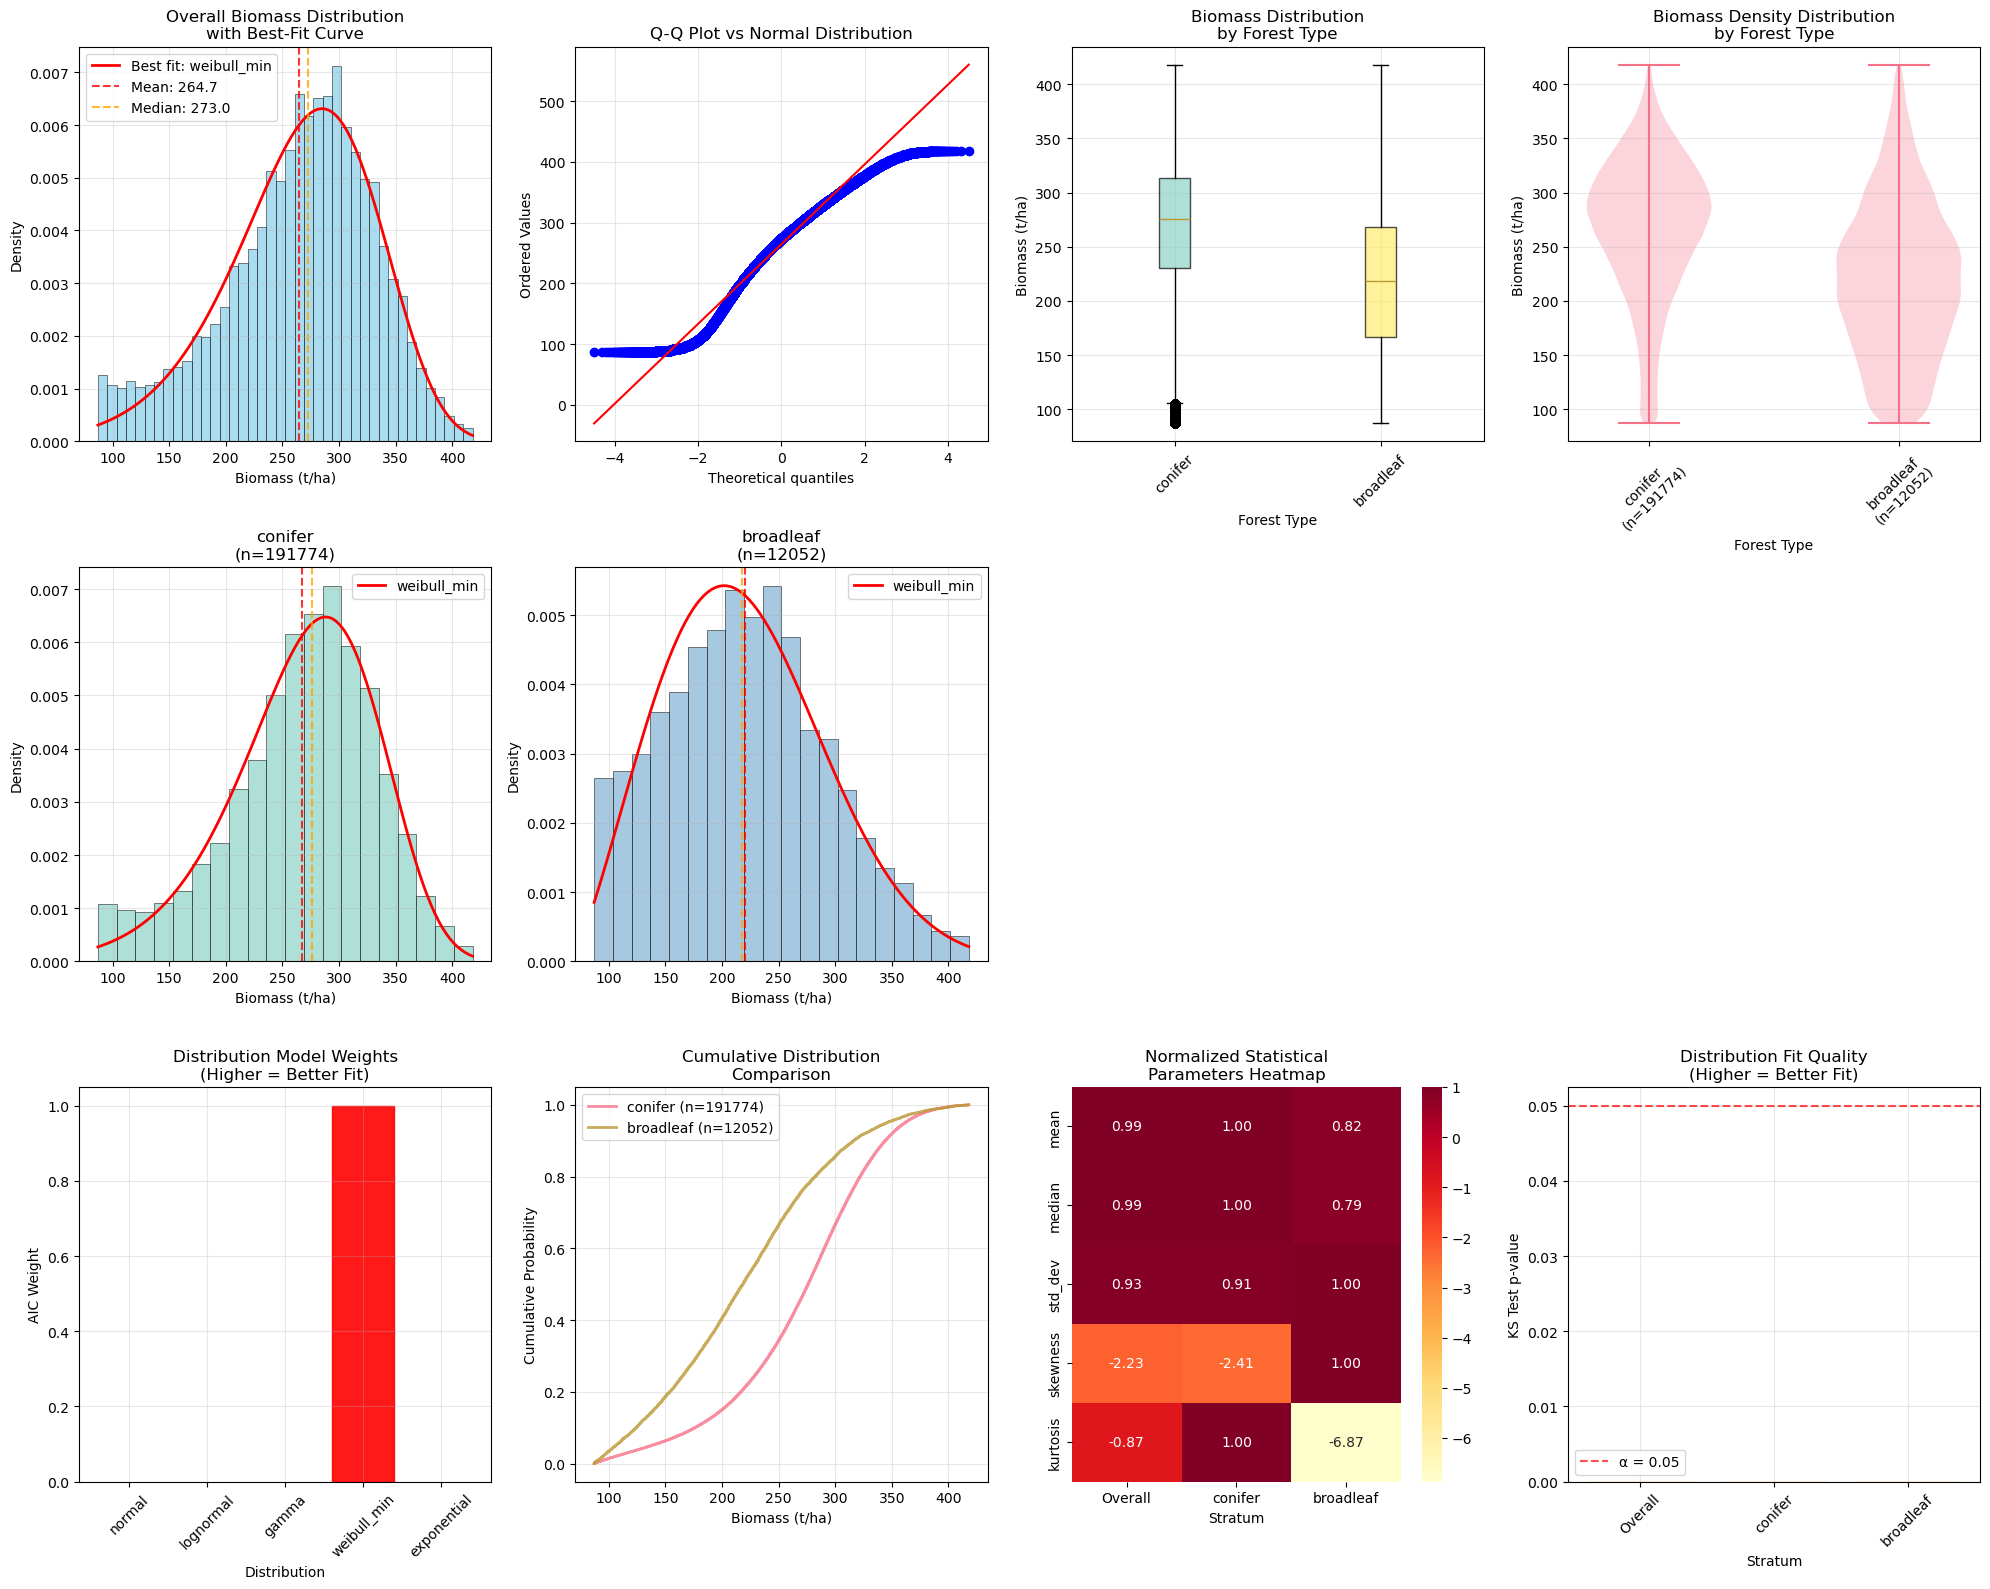


💾 Exporting results...
📁 Descriptive statistics saved to: .\biomass_descriptive_statistics.csv
📁 Distribution parameters saved to: .\biomass_distribution_parameters.csv
📄 Detailed report saved to: .\biomass_statistical_summary.txt
✅ All results exported successfully!

🎉 Statistical analysis completed successfully!


In [19]:
analyzer = analyze_biomass_csv('harvest_pixels_analysis_high_prob.csv')